# Task 2 Lauren Friend

In [1]:
#Import Packages

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn import datasets
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit, KFold
from sklearn.impute import SimpleImputer
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load the Data as a pd DataFrame
dataset = pd.read_csv('sydney_data.csv')

In [3]:
#Drop the variables that are not important to price
dataset = dataset.drop(['street', 'country', 'date'], axis=1)

In [7]:
# Remove homes with a selling price of 0
for index, row in dataset.iterrows():
    if row['price'] == 0:
        dataset.drop(row['price'])

In [8]:
dataset['statezip'].describe()

count         4600
unique          77
top       WA 98103
freq           148
Name: statezip, dtype: object

# This section was decided against due to the decrease in R^2
but this is interesting to note that this does not improve score, and therefore I am still including the process so that it is not repeated by other students in the future. 

There are 77 different zip codes, but this is not helpful for the model. Because zip code is very important to the location, I need this to be a part of my data. because many homeowners have children, I am going to group the zip codes by the school district they belong to. Then, I will use the school district's test scores to rank the groupings 1,2,3,4... in terms of desirability for a home purchaser.

the school districts are ranked by: 

1. Lake Washington School District
2. Seattle Public Schools
3. Bellevue School District
4. Mercer Island School District
5. Issiquah School District
6. Northshore School District
according to the popular site https://backgroundchecks.org/top-school-districts-in-washington.html

https://statisticalatlas.com/school-district/Washington/Lake-Washington-School-District/Overview
https://statisticalatlas.com/school-district/Washington/Seattle-School-District/Overview
https://statisticalatlas.com/school-district/Washington/Bellevue-School-District/Overview
https://statisticalatlas.com/school-district/Washington/Issaquah-School-District/Overview
https://statisticalatlas.com/school-district/Washington/Mercer-Island-School-District/Overview
https://statisticalatlas.com/school-district/Washington/Northshore-School-District/Overview

In [ ]:
LWSD = [98004, 98005, 98007, 98008, 98011, 98033, 98034, 98039, 98052, 98053, 98072, 98074, 98075, 98077]
SPS = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 
       98117, 98118, 98119, 98121, 98122, 98125, 98126, 98133, 98134, 98136, 98144, 98146, 98154, 
       98164, 98168, 98174, 98177, 98178, 98195, 98199]
BSD = [98004, 98005, 98006, 98007, 98008, 98027, 98033, 98039, 98052, 98056, 98059]
MISD = [98004, 98006, 98040]
ISD= [98006, 98008, 98024, 98027, 98029, 98038, 98050, 98056, 98058, 98059, 98065, 98074, 98075]
NSSD = [98011, 98012, 98021, 98028, 98034, 98036, 98052, 98072, 98077, 98155, 98296]

In [ ]:
for index, row in dataset.iterrows():
    zipcode = row['statezip']
    if type(zipcode) == str:
        zipc = int(zipcode.split()[1])
    else:
        zipc = int(zipcode)
    if zipc in LWSD:
        dataset.replace(to_replace=zipcode, value=1, inplace=True)
    elif zipc in SPS:
        dataset.replace(to_replace=zipcode, value=2, inplace=True)
    elif zipc in BSD:
        dataset.replace(to_replace=zipcode, value=3, inplace=True)
    elif zipc in MISD:
        dataset.replace(to_replace=zipcode, value=4, inplace=True)
    elif zipc in ISD:
        dataset.replace(to_replace=zipcode, value=5, inplace=True)
    elif zipc in NSSD:
        dataset.replace(to_replace=zipcode, value=6, inplace=True)
    else:
        dataset.replace(to_replace=zipcode, value=7, inplace=True)

dataset['statezip'].describe()

In [ ]:
plt.hist(dataset['statezip'], bins='auto')
plt.title('location based on school district rank')
plt.xlabel('school district ranking')
plt.ylabel('number of homes')
plt.tight_layout()

Much better! Now the location information is coded by the school district ranking, with 1 being better than 7. Even if home buyers do not have children, better public schools generally mean higher property taxes in that area, and therefore highter home prices

In [9]:
#Create the target and remove it from the dataset
target = dataset['price']
dataset = dataset.drop(['price'], axis=1)
target

0       3.130000e+05
1       2.384000e+06
2       3.420000e+05
3       4.200000e+05
4       5.500000e+05
            ...     
4595    3.081667e+05
4596    5.343333e+05
4597    4.169042e+05
4598    2.034000e+05
4599    2.206000e+05
Name: price, Length: 4600, dtype: float64

In [10]:
# 2.1 continuous vs categorical
continuous_list = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','yr_renovated']
categorical_list = []
for item in dataset.columns:
    if item not in continuous_list:
        categorical_list.append(item)
categorical_list

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'city',
 'statezip']

# 2.2 

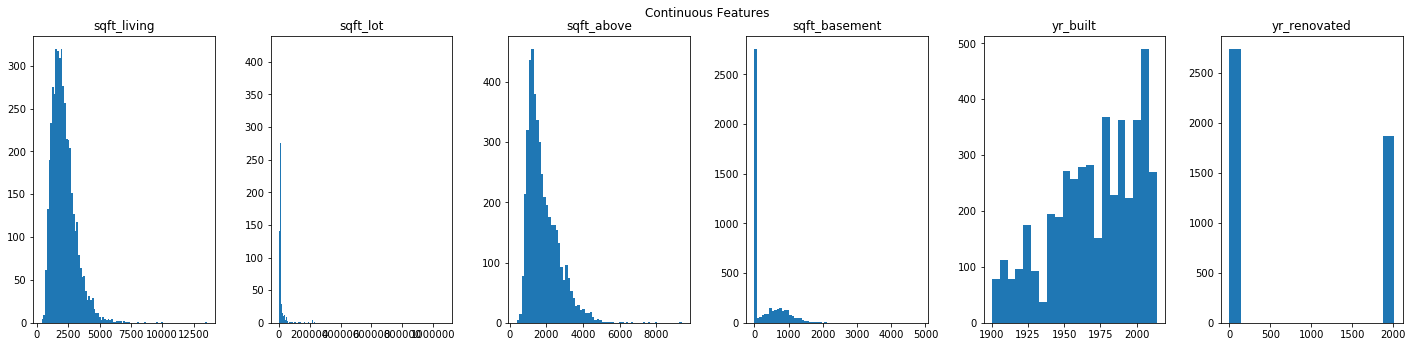

In [11]:
i=0
fig1, ax = plt.subplots(1,len(continuous_list), figsize=(20,5))
fig1.suptitle("Continuous Features")
for feature in continuous_list:
    ax[i].hist(dataset[feature], bins="auto")
    ax[i].set_title(feature)
    i+=1
plt.tight_layout(pad=2)

Text(0.5, 1.0, 'Housing Prices')

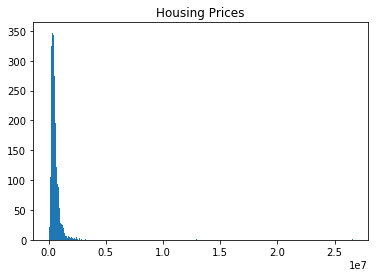

In [12]:
plt.hist(target, bins="auto")
plt.title('Housing Prices')

Reflection: 

It appears that there is one outlier in the home price data (target) that is skewing the data. There is also an outlier in the square footage data. this is likely to be Bill Gates' home. This does require special treatment and should be removed for scaling purposes.

# 2.3

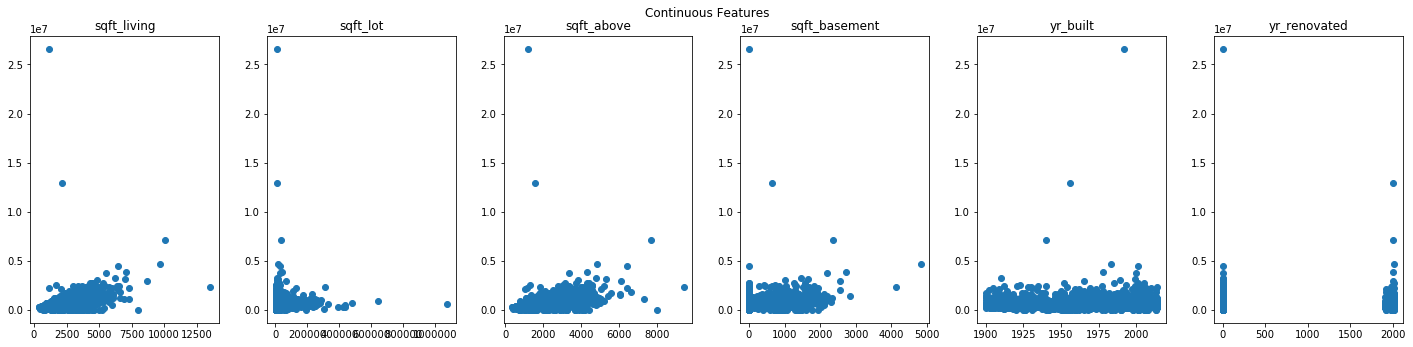

In [16]:
i=0
fig1, ax = plt.subplots(1,len(continuous_list), figsize=(20,5))
fig1.suptitle("Continuous Features")
for feature in continuous_list:
    ax[i].scatter(dataset[feature], target)
    ax[i].set_title(feature)
    i+=1
plt.tight_layout(pad=2)

#housing prices by school district, shown without outliers
plt.scatter(dataset['statezip'], target)
plt.ylim(0,5000000)
plt.title('School district affect on home price')
plt.xlabel('school district')
plt.ylabel('home price')

#housing prices by city, shown without outliers
plt.scatter(dataset['city'], target)
plt.ylim(0,5000000)
plt.title('city affect on home price')
plt.xlabel('city')
plt.ylabel('home price')

# 2.4

In [17]:
#Splitting the data
X_trainval, X_test, y_trainval, y_test = train_test_split(dataset, target, shuffle=True, random_state=3)

Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters and no scaling. 

In [19]:
columntransformer = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='median', missing_values=0), continuous_list),
    ('targetencoder', TargetEncoder(), categorical_list[-1]),
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_list[:-1]) ])
    #('scaler', StandardScaler(), continuous_lsit)])
linear_pipeline = make_pipeline(columntransformer, LinearRegression())
ridge_pipeline = make_pipeline(columntransformer, Ridge())
lasso_pipeline = make_pipeline(columntransformer, Lasso(max_iter=5000, tol=0.01))
elastic_pipeline = make_pipeline(columntransformer, ElasticNet(max_iter=5000))

In [20]:
lin_scores= cross_val_score(linear_pipeline,X_trainval,y_trainval, cv=10)
lin_scores
print(f'mean score is {lin_scores.mean()}, the std is {lin_scores.std()}')

mean score is 0.6313602533500842, the std is 0.18371194619212391


In [21]:
ridge_scores = cross_val_score(ridge_pipeline, X_trainval, y_trainval, cv=10)
ridge_scores
print(f'mean score is {ridge_scores.mean()}, the std is {ridge_scores.std()}')

mean score is 0.5924410025530781, the std is 0.1595383892582347


In [22]:
lasso_scores = cross_val_score(lasso_pipeline, X_trainval, y_trainval, cv=10)
print(f'mean score is {lasso_scores.mean()}, the std is {lasso_scores.std()}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90995231841398.94, tolerance: 5571892073241.514
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27401586693481.453, tolerance: 5708632651874.686
  model = cd_fast.sparse_enet_coordinate_descent(


mean score is 0.6280967899609287, the std is 0.1806186463244442


In [29]:
elastic_scores = cross_val_score(elastic_pipeline, X_trainval, y_trainval, cv=10)
print(f'mean score is {elastic_scores.mean()}, the std is {elastic_scores.std()}')

mean score is 0.6226172719339917, the std is 0.16693283708191362


The strategy of using school districts rather than zip codes does not appear to be working well. In previous attempts with this question, the results were much higher.

Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters and StandardScaler() to see if scaling changes the results

In [120]:
s_columntransformer = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='median', missing_values=0), continuous_list),
    ('targetencoder', TargetEncoder(), categorical_list[-1]),
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_list[:-1]),
    ('scaler', StandardScaler(), continuous_list),
    #('scaler', RobustScaler(), continuous_list),
    ])
s_linear_pipeline = make_pipeline(s_columntransformer, LinearRegression())
s_ridge_pipeline = make_pipeline(s_columntransformer, Ridge())
s_lasso_pipeline = make_pipeline(s_columntransformer, Lasso(max_iter=5000, tol=0.1))
s_elastic_pipeline = make_pipeline(s_columntransformer, ElasticNet(max_iter=5000, tol=0.1))

kfold = sklearn.model_selection.KFold(n_splits=10, shuffle=True)

In [25]:
s_lin_scores= cross_val_score(s_linear_pipeline,X_trainval,y_trainval, cv=kfold)
print(f'with standardscaler the mean score is {s_lin_scores.mean()}, the std is {s_lin_scores.std()}, the difference is {abs(s_lin_scores.mean()-lin_scores.mean())}')

with standardscaler the mean score is 0.6356579305336453, the std is 0.18354223761809962, the difference is 0.0042976771835611105


In [26]:
s_ridge_scores= cross_val_score(s_ridge_pipeline,X_trainval,y_trainval, cv=kfold)
print(f'with standardscaler the mean score is {s_ridge_scores.mean()}, the std is {s_ridge_scores.std()}, the difference is {abs(s_ridge_scores.mean()-ridge_scores.mean())}')

with standardscaler the mean score is 0.5930518079450537, the std is 0.14436141816821163, the difference is 0.0006108053919756662


In [27]:
s_lasso_scores= cross_val_score(s_lasso_pipeline,X_trainval,y_trainval, cv=kfold)
print(f'with standardscaler the mean score is {s_lasso_scores.mean()}, the std is {s_lasso_scores.std()}, the difference is {abs(s_lasso_scores.mean()-lasso_scores.mean())}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51872769714253.336, tolerance: 43236000230263.625
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128439076170417.12, tolerance: 58564266902346.31
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126618992523200.84, tolerance: 58506714118959.09
  model = cd_fast.sparse_enet

with standardscaler the mean score is 0.6279812155468512, the std is 0.16955930138632377, the difference is 0.00011557441407750169


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127083019657020.77, tolerance: 58917631780436.7
  model = cd_fast.sparse_enet_coordinate_descent(


In [30]:
s_elastic_scores= cross_val_score(s_elastic_pipeline,X_trainval,y_trainval, cv=kfold)
print(f'with standardscaler the mean score is {s_elastic_scores.mean()}, the std is {s_elastic_scores.std()}, the difference is {abs(s_elastic_scores.mean()-elastic_scores.mean())}')

with standardscaler the mean score is 0.6283564537227155, the std is 0.13535356475042154, the difference is 0.005739181788723791


Scaling the continuous variables did help to improve the result, however the improvement was very small.

# 2.5 Tune parameters with GridSearchCV
linear_regression: N/A
ridge: 'ridge__alpha'
lasso: 'lasso__alpha'
elastic: 'elasticnet__alpha'

In [ ]:
for k in s_ridge_pipeline.get_params().keys():
    print(k)

In [132]:
#Choosing the parameters to tune

ridge_grid = {'ridge__alpha':np.arange(0,9,0.01)}
lasso_grid = {'lasso__alpha':[100,500,1000,1250,1500]} 
#lasso_grid = {'lasso__alpha':np.logspace(-3,0,10)}
elasticnet_grid = {'elasticnet__alpha':[.01,.02,.03], 'elasticnet__l1_ratio':[.7,.8,1]}
elasticnet_grid1 = {'elasticnet__alpha':[0.0001,.001,.01,.02,.03,.1]}
elasticnet_grid2 = {'elasticnet__l1_ratio':[0,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,1]}

In [40]:
#It is likely that the reason it is getting worse (slightly) is due to shuffleing 

r_grid = GridSearchCV(s_ridge_pipeline, ridge_grid, cv=kfold)
r_grid.fit(X_trainval, y_trainval)
print(r_grid.best_params_)
print(r_grid.best_score_)

{'ridge__alpha': 3.36}
0.5986241296238161


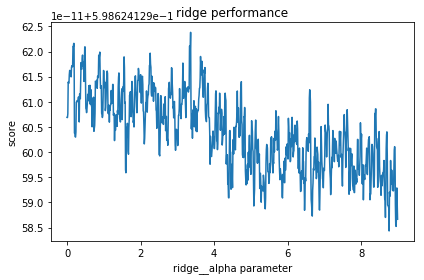

In [41]:
#Ridge performance 
ridge_performance = r_grid.cv_results_['mean_test_score']
ridge_params = r_grid.param_grid['ridge__alpha']

plt.plot(ridge_params, ridge_performance)
plt.title("ridge performance")
plt.xlabel("ridge__alpha parameter")
plt.ylabel('score')
plt.tight_layout()

In [72]:
#Lasso Grid Search
l_grid = GridSearchCV(s_lasso_pipeline, lasso_grid, cv=10)
l_grid.fit(X_trainval, y_trainval)
print(l_grid.best_params_)
print(l_grid.best_score_)

{'lasso__alpha': 1250}
0.6366380268734747


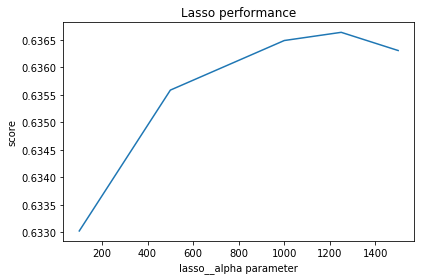

In [73]:
#Lasso performance for range of 0 to 500
lasso_performance = l_grid.cv_results_['mean_test_score']
lasso_params = l_grid.param_grid['lasso__alpha']


plt.plot(lasso_params, lasso_performance)
plt.title("Lasso performance")
plt.xlabel("lasso__alpha parameter")
plt.ylabel('score')
plt.tight_layout()

In [121]:
#Testing the alpha parameter
e_grid1 = GridSearchCV(s_elastic_pipeline, elasticnet_grid1, cv=5)
e_grid1.fit(X_trainval, y_trainval)
print(e_grid1.best_params_)
print(e_grid1.best_score_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110993591619576.69, tolerance: 46859812179895.59
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124859096320139.39, tolerance: 55931513176119.5
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113436116505198.94, tolerance: 53010300282391.73
  model = cd_fast.sparse_enet_c

{'elasticnet__alpha': 0.03}
0.607114467219912


In [126]:
#testing the l1 parameter
e_grid2 = GridSearchCV(s_elastic_pipeline, elasticnet_grid2, cv=5)
e_grid2.fit(X_trainval, y_trainval)
print(e_grid2.best_params_)
print(e_grid2.best_score_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121988031220955.28, tolerance: 46859812179895.59
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138292506503165.58, tolerance: 55931513176119.5
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127407434498286.78, tolerance: 53010300282391.73
  model = cd_fast.sparse_enet_c

{'elasticnet__l1_ratio': 0.8}
0.593376722847418


In [134]:
#Testing the parameters together
e_grid = GridSearchCV(s_elastic_pipeline, elasticnet_grid, cv=2)
e_grid.fit(X_trainval, y_trainval)
print(e_grid.best_params_)
print(e_grid.best_score_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94128176026658.73, tolerance: 34210290636245.17
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34344575163194.105, tolerance: 28605109927726.83
  model = cd_fast.sparse_enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93953685409069.2, tolerance: 34210290636245.17
  model = cd_fast.sparse_enet_coo

{'elasticnet__alpha': 0.03, 'elasticnet__l1_ratio': 0.7}
0.513256996392103


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134827519073067.34, tolerance: 62835443696780.47
  model = cd_fast.sparse_enet_coordinate_descent(


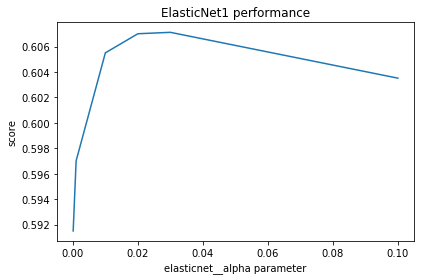

In [122]:
#elasticnet alpha parameter performance
enet1_performance = e_grid1.cv_results_['mean_test_score']
enet_param1 = e_grid1.param_grid['elasticnet__alpha']


plt.plot(enet_param1, enet1_performance)
plt.title("ElasticNet1 performance")
plt.xlabel("elasticnet__alpha parameter")
plt.ylabel('score')
plt.tight_layout()

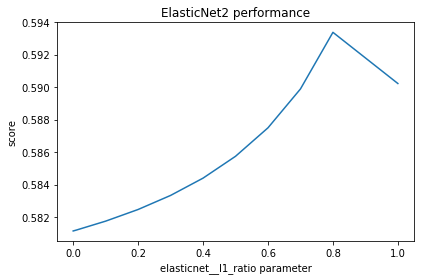

In [127]:
#elasticnet l1 parameter performance
enet_performance2 = e_grid2.cv_results_['mean_test_score']
enet_param2 = e_grid2.param_grid['elasticnet__l1_ratio']


plt.plot(enet_param2, enet_performance2)
plt.title("ElasticNet2 performance")
plt.xlabel("elasticnet__l1_ratio parameter")
plt.ylabel('score')
plt.tight_layout()

# 2.6 Visualizing the 20 most important coefficients in Ridge, Lasso, and ElasticNet

In [165]:
# Features for ridge

ridge_cat_features = r_grid.best_estimator_.steps[0][1].named_transformers_['encoder'].get_feature_names()
ridge_cont_features = np.array(continuous_list)
ridge_feature_list = np.hstack([ridge_cat_features, ridge_cont_features])

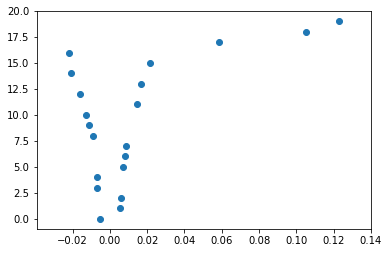

In [167]:
# indicies for ridge
#feature weights for ridge
ridge_weights = r_grid.best_estimator_.steps[1][1].coef_
ridge_weights= ridge_weights[-100:]
ridge_indices = np.argsort(abs(ridge_weights))
plt.scatter(ridge_weights[ridge_indices][-20:], range(20))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

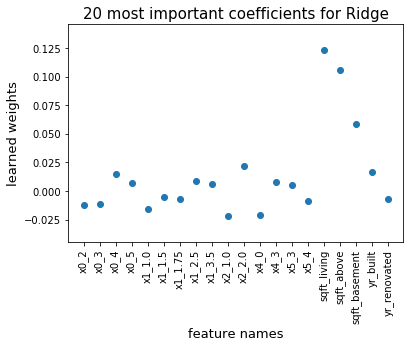

In [169]:
#Plotting the 20 most important features and their weights for Ridge
ridge_f_ind = np.sort(ridge_indices[-20:])
plt.scatter(ridge_feature_list[ridge_f_ind], ridge_weights[ridge_f_ind])
plt.title('20 most important coefficients for Ridge',fontsize=15)
plt.ylabel('learned weights', fontsize=13)
plt.xlabel('feature names', fontsize=13)
plt.xticks(rotation='vertical')


In [176]:
#Features for Lasso
lasso_cat_features = l_grid.best_estimator_.steps[0][1].named_transformers_['encoder'].get_feature_names()
lasso_cont_features = np.array(continuous_list)
lasso_feature_list = np.hstack([lasso_cat_features, lasso_cont_features])

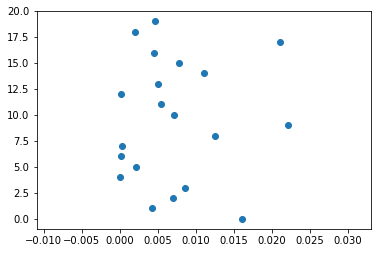

In [179]:
#Indicies for Lasso

lasso_weights = l_grid.best_estimator_.steps[1][1].coef_
lasso_weights= lasso_weights[-100:]
lasso_indices = np.argsort(abs(lasso_weights))
plt.scatter(abs(ridge_weights[lasso_indices][-20:]), range(20))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

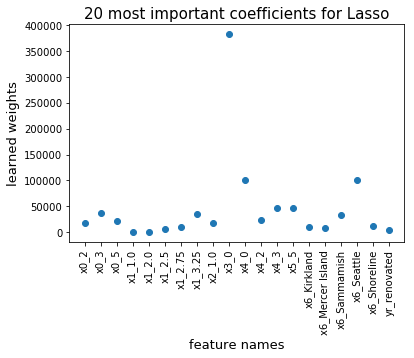

In [181]:
#Plotting the 20 most important features and their weights for Lasso
lasso_f_ind = np.sort(lasso_indices[-20:])
plt.scatter(lasso_feature_list[lasso_f_ind], abs(lasso_weights[lasso_f_ind]))
plt.title('20 most important coefficients for Lasso',fontsize=15)
plt.ylabel('learned weights', fontsize=13)
plt.xlabel('feature names', fontsize=13)
plt.xticks(rotation='vertical')


In [187]:
#Features for ElasticNet
elasticnet_cat_features = e_grid.best_estimator_.steps[0][1].named_transformers_['encoder'].get_feature_names()
elasticnet_cont_features = np.array(continuous_list)
eastic_feature_list = np.hstack([elasticnet_cat_features,elasticnet_cont_features])

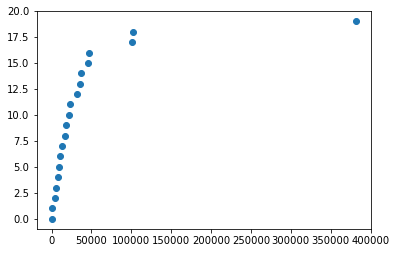

In [188]:
#Indicies for ElasticNet

elastic_weights = l_grid.best_estimator_.steps[1][1].coef_
elastic_weights= elastic_weights[-100:]
elastic_indices = np.argsort(abs(elastic_weights))
plt.scatter(abs(elastic_weights[elastic_indices][-20:]), range(20))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

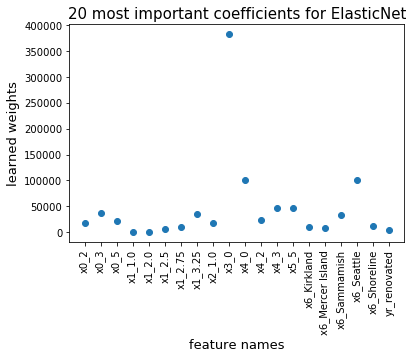

In [190]:
# Plotting the 20 most important features and their weights for ElasticNet
elastic_f_ind = np.sort(elastic_indices[-20:])
plt.scatter(eastic_feature_list[elastic_f_ind], abs(elastic_weights[elastic_f_ind]))
plt.title('20 most important coefficients for ElasticNet',fontsize=15)
plt.ylabel('learned weights', fontsize=13)
plt.xlabel('feature names', fontsize=13)
plt.xticks(rotation='vertical')

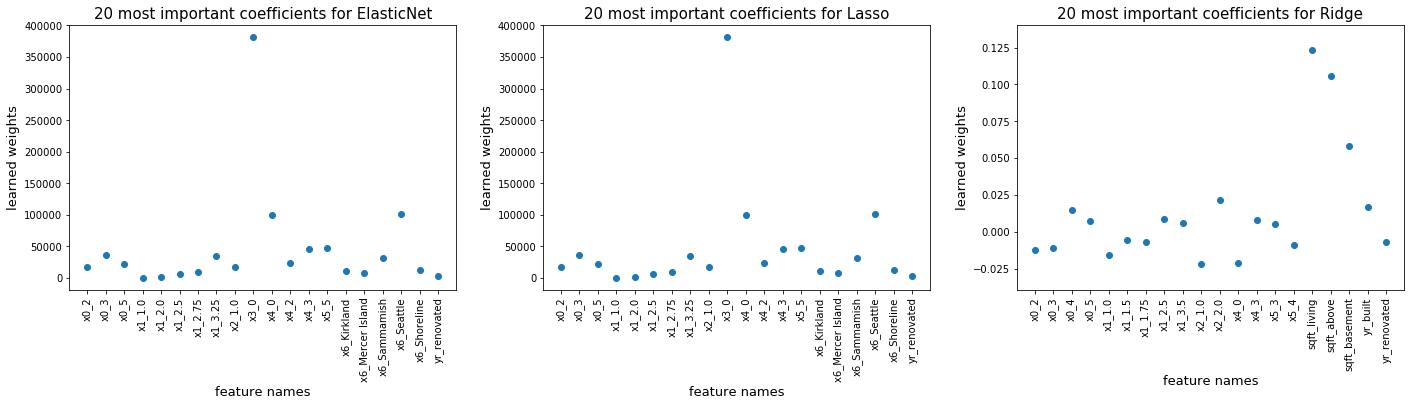

In [213]:
fig4, ax = plt.subplots(1,3,figsize=(20,6))
ax1,ax2,ax3 = ax.ravel()

# Figure 1, ElasticNet
ax1.scatter(eastic_feature_list[elastic_f_ind], abs(elastic_weights[elastic_f_ind]))
ax1.set_title('20 most important coefficients for ElasticNet',fontsize=15)
ax1.set_ylabel('learned weights', fontsize=13)
ax1.set_xlabel('feature names', fontsize=13)
ax1.tick_params(axis='x',rotation =90)

# Figure 2, Lasso
ax2.scatter(lasso_feature_list[lasso_f_ind], abs(lasso_weights[lasso_f_ind]))
ax2.set_title('20 most important coefficients for Lasso',fontsize=15)
ax2.set_ylabel('learned weights', fontsize=13)
ax2.set_xlabel('feature names', fontsize=13)
ax2.tick_params(axis='x',rotation =90)

# Figure 3, Ridge
ax3.scatter(ridge_feature_list[ridge_f_ind], ridge_weights[ridge_f_ind])
ax3.set_title('20 most important coefficients for Ridge',fontsize=15)
ax3.set_ylabel('learned weights', fontsize=13)
ax3.set_xlabel('feature names', fontsize=13)
ax3.tick_params(axis='x',rotation =90)

fig4.tight_layout(pad=2)

# 2.6 Reflection

The different models mostly agree on which features are important. For example, x3_0 is extremely important in ElasticNet and Lasso, but it is not weighted as heavily in Ridge. In Ridge the most important feature is the square feet of living space. 